In [1]:
import numpy as np
from minigrid.minigrid_env import MiniGridEnv
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
import matplotlib.pyplot as plt
from minigrid.wrappers import RGBImgObsWrapper
# from gymnasium.wrappers import RecordVideo

pygame 2.5.2 (SDL 2.28.3, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# cuda visible device = 1 in python
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=8,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir
        self.render_mode = "rgb_array"
        mission_space = MissionSpace(mission_func=self._gen_mission)

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            max_steps=256,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate vertical separation wall
        for i in range(0, height):
            self.grid.set(5, i, Wall())
        
        # Place the door and key
        self.grid.set(5, 6, Door(COLOR_NAMES[0], is_locked=True))
        self.grid.set(3, 6, Key(COLOR_NAMES[0]))

        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), width - 2, height - 2)

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

/opt/anaconda3/envs/minigrid/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


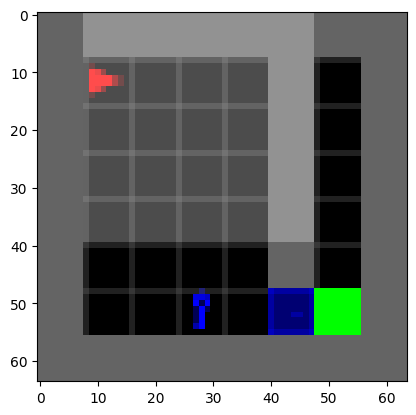

In [3]:
env = SimpleEnv()
env = RGBImgObsWrapper(env)
obs, _ = env.reset()
plt.imshow(obs['image'])

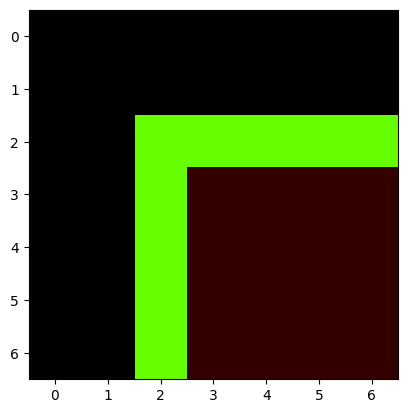

In [57]:
import gymnasium as gym
env = gym.make('MiniGrid-MultiRoom-N6-v0', render_mode='rgb_array')
obs, _ = env.reset()
plt.imshow(obs['image']/obs['image'].max())

0


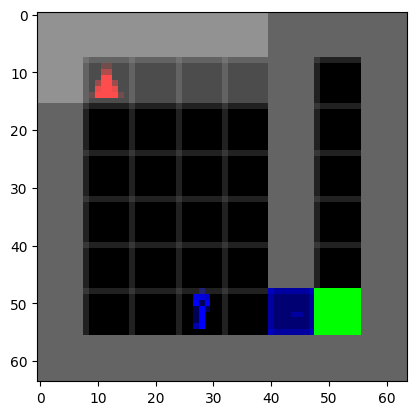

In [4]:
import random
action = random.randint(0, env.action_space.n - 1)
obs, reward, done, info, _ = env.step(action)
print(action)
plt.imshow(obs['image'])

In [46]:
env

<RGBImgObsWrapperWGWGWGWGWGWGWGWG
WG        WG  WG
WG      ^^WG  WG
WG        WG  WG
WG        WG  WG
WG        WG  WG
WG    KB  LBGGWG
WGWGWGWGWGWGWGWG>

In [ ]:
# Q-learning settings
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0
min_epsilon = 0.1
epsilon_decay = 0.99
episodes = 1000

In [ ]:
# Initialize Q-table
action_space = env.action_space.n
state_space = np.prod(env.observation_space.shape)  # Assuming flat observation space
Q = np.random.uniform(low=0, high=1, size=(state_space, action_space))

def get_state_index(observation):
    """ Flatten the observation to a single integer for indexing Q-table """
    return np.ravel_multi_index(observation.astype(int), env.observation_space.shape)

def epsilon_greedy_policy(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore: select a random action
    else:
        return np.argmax(Q[state])  # Exploit: select the best action from Q-table

# Training loop
for episode in range(episodes):
    observation = env.reset()
    state = get_state_index(observation)
    done = False
    
    while not done:
        action = epsilon_greedy_policy(state, epsilon)  # Decide action
        next_observation, reward, done, info = env.step(action)  # Take action
        next_state = get_state_index(next_observation)  # Get new state
        
        # Q-learning update
        best_next_action = np.argmax(Q[next_state])
        td_target = reward + discount_factor * Q[next_state][best_next_action]
        td_error = td_target - Q[state][action]
        Q[state][action] += learning_rate * td_error

        state = next_state  # Update state to new state
        
    # Decay epsilon
    if epsilon > min_epsilon:
        epsilon *= epsilon_decay